# Sampling and Reliability: Assign 5
by Arvind Ilamaran

## Sub-sampling approaches:
I am working on a corpus of fake news articles. They also include articles classified as `bullshit` and `hoax` and `rumour`.   
**Interested Keywords**: `trump`,`hillary`,`war`,`russia`,`syria`,`president`,`peace`,`oil`...
### Word-trend
The first strategy is to compute the top 10 that have experienced the most linguistic change. Choose keyword(s) relevant to the subsetting requirement and then simply check if these keywords are present in the normalized sentences from the corpora. Subset if, yes. 
### Word Similarity
Using Doc2vec calculate the cosine similarity between corpus and keyword(s). Fix a threshold range of the cosine measure and subset the documents whose cosine similarity falls in the range.
### Conditional Frequency
To identify fake news related to Trump and Hillary, subset articles whose conditional frequency of co-occurence of `hillary` and `trump` is within a specified threshold range.

## Reliability

In this case, we made a list of 100 randomly sampled fake news articles from the categories of `bullshit` (1), `fake` (2), `hoax` (3) and `rumor` (4). 3 coders were asked to classify the articles into one of the four categories.

In [44]:
# loading the required libraries
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import copy

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

from functools import reduce
from itertools import permutations
import math

import pyanno #On python3 make sure to pip install pyanno3
#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

In [30]:
x = np.loadtxt("../DATA/mTurk_arvind.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [33]:
anno.missing_values

[-1]

## Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [34]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.08888889, 0.22962963, 0.34074074, 0.34074074])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[0. 1. 0. 0.]
 [0. 1. 2. 1.]
 [0. 1. 8. 1.]
 [1. 4. 2. 4.]]


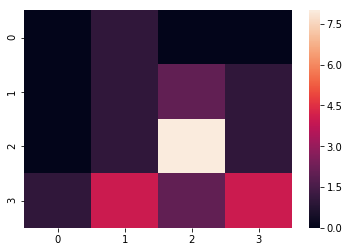

In [36]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [37]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.27994555353901995

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [39]:
krippendorffs_alpha(anno.annotations[::])

0.2805656486300697

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [40]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.2983490566037736

In [41]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.29834906 0.14229249        nan]
 [0.29834906 1.         0.06684374 0.46492806]
 [0.14229249 0.06684374 1.         0.07855626]
 [       nan 0.46492806 0.07855626 1.        ]]


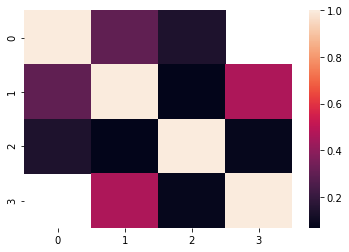

In [42]:
ax = seaborn.heatmap(m)
plt.show()

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [45]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.21019392074247842

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [46]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.26297534993187144

Or averaged over the total:

In [47]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.33805892865376375

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

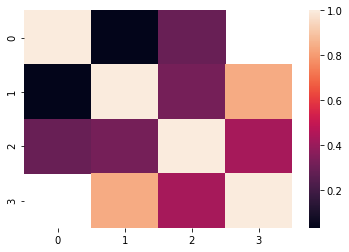

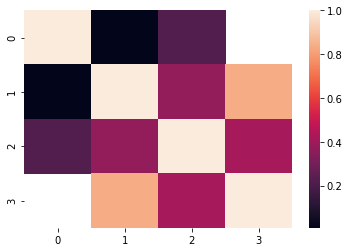

In [48]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [49]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.38341285179376094 0.37115376073366785


## Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading.

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [51]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,4)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.78836542 0.08454313 0.10122547 0.02586598]
  [0.1590366  0.57412512 0.20912836 0.05770992]
  [0.12344892 0.19622807 0.47822758 0.20209543]
  [0.02594739 0.10241079 0.20343513 0.66820668]]

 [[0.73537222 0.22976514 0.02401494 0.0108477 ]
  [0.24496897 0.52855634 0.08833111 0.13814358]
  [0.0154149  0.08326735 0.73628273 0.16503502]
  [0.02418777 0.18711397 0.21148131 0.57721695]]

 [[0.8312431  0.09360958 0.04253921 0.03260812]
  [0.25247394 0.53717455 0.12630692 0.08404459]
  [0.04058436 0.20107018 0.63559237 0.12275309]
  [0.02072495 0.08482333 0.17795573 0.71649599]]

 [[0.69746593 0.1515996  0.07576552 0.07516896]
  [0.21629777 0.60432942 0.11659863 0.06277417]
  [0.11364136 0.10581391 0.57480268 0.20574205]
  [0.01767575 0.0826336  0.10812106 0.79156958]]]
-184.6154183862834


Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [52]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [53]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.90915772e-001 1.56775211e-001 5.23090175e-002 5.92182767e-187]
  [1.89790947e-001 5.44759077e-001 1.16733118e-001 1.48716858e-001]
  [4.82844152e-002 1.08979443e-001 6.61022195e-001 1.81713946e-001]
  [1.19702882e-064 5.27674576e-002 1.37623256e-001 8.09609286e-001]]

 [[7.88688084e-001 1.58638293e-001 5.26736229e-002 0.00000000e+000]
  [1.43056206e-001 6.60550465e-001 1.48511951e-001 4.78813774e-002]
  [4.04035419e-002 1.44309955e-001 6.96931189e-001 1.18355314e-001]
  [9.93354766e-008 6.76221086e-002 1.44985373e-001 7.87392419e-001]]

 [[7.89514976e-001 1.57672494e-001 5.28125299e-002 0.00000000e+000]
  [1.95128843e-001 5.98818553e-001 1.61746312e-001 4.43062920e-002]
  [5.84480497e-002 1.41193987e-001 5.93750449e-001 2.06607514e-001]
  [3.24643520e-194 6.71318089e-002 1.76702048e-001 7.56166143e-001]]

 [[7.88779570e-001 1.58878016e-001 5.23424134e-002 3.75082356e-295]
  [1.28159064e-001 7.15520465e-001 1.11760400e-001 4.45600710e-002]
  [4.54258335e-002 1.50788263e-001 6.72477

/Users/arvindilamaran/anaconda3/lib/python3.6/site-packages/pyanno/util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [54]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.00000000e+000 1.11432950e-002 4.31500634e-002 9.45706642e-001]
 [3.19166750e-189 8.77249890e-001 7.07915217e-002 5.19585888e-002]
 [7.44560058e-189 1.29410088e-001 2.02728504e-001 6.67861408e-001]
 [5.76200901e-002 6.47935191e-001 2.94444719e-001 6.97943642e-077]
 [6.35015027e-005 2.76524554e-002 9.42112525e-001 3.01715183e-002]
 [5.89204284e-006 7.85801779e-003 9.82769454e-001 9.36663655e-003]
 [4.45332696e-003 3.08211290e-001 3.95154714e-001 2.92180670e-001]
 [7.44560058e-189 1.29410088e-001 2.02728504e-001 6.67861408e-001]
 [7.44560058e-189 1.29410088e-001 2.02728504e-001 6.67861408e-001]
 [6.70746825e-004 9.91189720e-002 7.64654898e-001 1.35555383e-001]
 [0.00000000e+000 3.30977227e-003 5.83099696e-002 9.38380258e-001]
 [7.38685809e-189 5.34596521e-001 1.82962927e-001 2.82440552e-001]
 [4.45332696e-003 3.08211290e-001 3.95154714e-001 2.92180670e-001]
 [0.00000000e+000 1.24726949e-001 5.60803952e-001 3.14469098e-001]
 [0.00000000e+000 5.60241625e-003 8.90072039e-001 1.04325545e-

Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [55]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x1154278d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1154bb080>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1155782e8>))

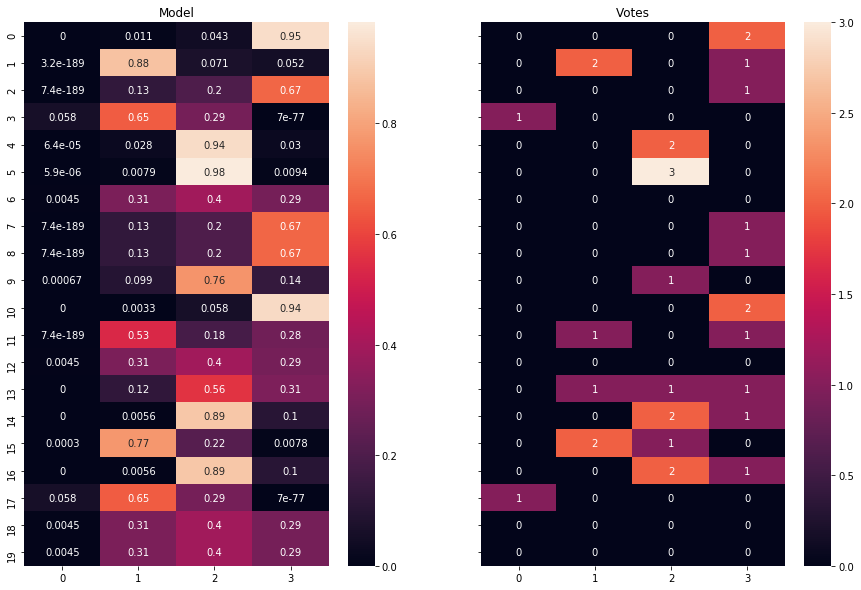

In [56]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [59]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 4)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.6392307  0.76174085 0.65066387 0.72435375]
-195.2379298245884


In [60]:
model.map(anno.annotations)

[0.61282812 0.75099673 0.42792893 0.82328261]
-170.64521719757164


In [61]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.69941531, 0.70852398, 0.43560225, 0.86499271],
       [0.69941531, 0.70852398, 0.43560225, 0.86499271],
       [0.64934604, 0.63717218, 0.48765718, 0.87465783],
       [0.64934604, 0.63717218, 0.48765718, 0.87465783],
       [0.68248076, 0.85484035, 0.37578509, 0.89085204],
       [0.69702122, 0.75764999, 0.57033563, 0.78874317],
       [0.69702122, 0.75764999, 0.57033563, 0.78874317],
       [0.69702122, 0.75764999, 0.57033563, 0.78874317],
       [0.73461326, 0.66835678, 0.38871137, 0.68550789],
       [0.73970658, 0.66924979, 0.37988926, 0.51345692],
       [0.73970658, 0.66924979, 0.37988926, 0.51345692],
       [0.73970658, 0.66924979, 0.37988926, 0.51345692],
       [0.73970658, 0.66924979, 0.37988926, 0.51345692],
       [0.50838571, 0.60490298, 0.61013421, 0.76539695],
       [0.37211355, 0.85191045, 0.54615196, 0.85110559],
       [0.53907035, 0.89344912, 0.57811569, 0.85358048],
       [0.64166109, 0.74349622, 0.59095182, 0.73673063],
       [0.64166109, 0.74349622,

In [63]:
posterior = model.infer_labels(anno.annotations)


Let's visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x115427a20>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11573ee10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11578c828>))

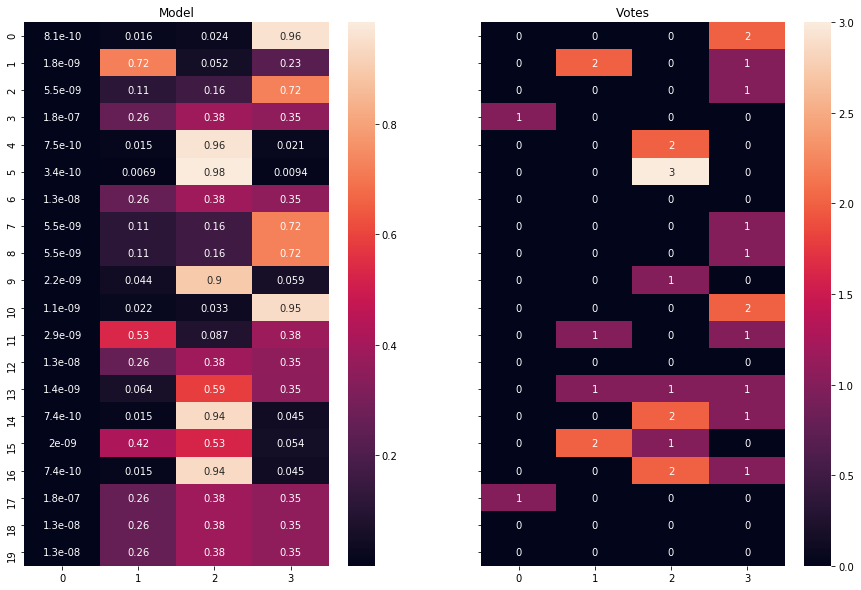

In [64]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

#### Coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [67]:
model = ModelBt.create_initial_state(4,4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

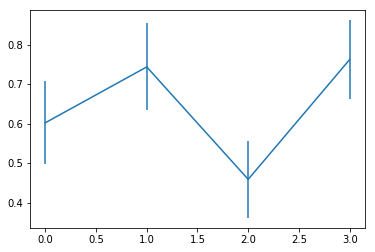

In [69]:
plt.figure()
plt.errorbar(range(4),y, yerr = y_ci)
plt.show()

Based on the analysis, we will probably remove Coder 3's data because it has the least accuracy likelihood.